<a href="https://colab.research.google.com/github/dustiny5/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
1+1
print('This is a change')
list = [2,5,7,23] # Doesn't mean anything unless it has context. Change the var list to another name will be quantifiable. Change list to number of apples

This is a change


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [108]:
# TODO - your code here
# Use what we did live in lecture as an example
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00485/google_review_ratings.csv')
df.head() # Gives the first 10 user data
df.shape # Description of the data and outputs 5456 data points of each of the 26 attributes
df.describe() # Gives useful information of mean median mode and helps can help us determine where most of data lie.
df.isnull().sum() #Gives a useful sum of NaN values for each attribute. There's 1 NaN values on category 12 & 24
df['Category 12'].describe() # Describe individual columns
df['Category 24'].describe()


count    5455.000000
mean        1.560755
std         1.171756
min         0.000000
25%         0.880000
50%         1.290000
75%         1.660000
max         5.000000
Name: Category 24, dtype: float64

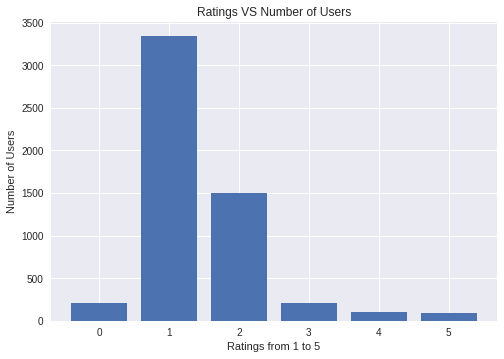

{0: 205, 1: 3344, 2: 1501, 3: 211, 4: 104, 5: 91}


In [109]:
import matplotlib.pyplot as plt

cat1 = [int(round(i)) for i in df['Category 1']]

rank = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0} # Gives ratings of 1 to 5 from left to right respectively
rating_number = [0,1,2,3,4,5]

#Iterate and puts the counts and adds the ranking to the dictionary
for i in range(6) :
  for j in range(len(cat1)):
    if cat1[j] == i:
      rank[i] += 1

#Plot the bar graph
plt.bar(rating_number, rank.values())
plt.xlabel('Ratings from 1 to 5')
plt.ylabel('Number of Users')
plt.title('Ratings VS Number of Users')
plt.show()

print(rank)

In [0]:
#1. I learn to make bar graphs using the matplotlib library and also how to extract data by using pandas.
#2. The most challenging part was condensing my code.
#3. I can count how many values by adding values to dictionary instead by using list. Using list has many steps if I were to add the total value
#4. How to write shorter and readable code. I believe that takes the most time out of everything

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.